# Modélisation et évaluation des modèles

Ce notebook entraîne et évalue différents modèles de Machine Learning pour la classification de sentiment sur les données de tweets prétraitées.

## 1- Importation des librairies

In [1]:
# Imports standards (bibliothèques intégrées à Python)
import sys
import os
import pickle  # Pour la sauvegarde et le chargement de modèles et d'objets Python

# Manipulation et traitement de données
import pandas as pd
import numpy as np

# Machine Learning
    # Scikit-learn (modèles, métriques, utilitaires)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

    # TensorFlow/Keras (modèles de deep learning)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten  # Couches Keras
from tensorflow.keras.preprocessing.sequence import pad_sequences # Pour le padding des séquences
from tensorflow.keras.optimizers.schedules import ExponentialDecay # Pour la décroissance du taux d'apprentissage

    # Hugging Face Transformers (modèles pré-entraînés)
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# Gensim (Word2Vec, FastText, Doc2Vec - embeddings)
from gensim.models import Word2Vec, FastText

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# MLflow (suivi des expériences)
import mlflow
import mlflow.sklearn  # Intégration MLflow pour scikit-learn
import mlflow.keras    # Intégration MLflow pour Keras
import tensorflow_hub as hub

# Imports de modules locaux (personnalisés)
sys.path.append('../src')
import model  # Fonctions pour créer les modèles (à remplacer par vos implémentations)
import evaluation  # Fonctions pour évaluer les modèles (à remplacer)


2025-02-10 08:58:12.938469: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-10 08:58:13.304443: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-10 08:58:13.306791: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-10 08:58:15.503453: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mehdi/Documents/OC/OC7/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Chargement des données

In [2]:
#@title 2.1 Chargement des données

# Chemin d'accès au dossier data
data_path = '../data/processed/'

# Charger les données prétraitées

## Données non vectorisées
X_train = pickle.load(open(data_path + 'X_train.pickle', 'rb'))
X_test = pickle.load(open(data_path + 'X_test.pickle', 'rb'))

## Labels
y_train = pickle.load(open(data_path + 'y_train.pickle', 'rb'))
y_test = pickle.load(open(data_path + 'y_test.pickle', 'rb'))

## Vectorisées TF-IDF
X_train_tfidf = pickle.load(open(data_path + 'X_train_tfidf.pickle', 'rb'))
X_test_tfidf = pickle.load(open(data_path + 'X_test_tfidf.pickle', 'rb'))

## Word2vec
X_train_w2v = pickle.load(open(data_path + 'X_train_word2vec.pickle', 'rb'))
X_test_w2v = pickle.load(open(data_path + 'X_test_word2vec.pickle', 'rb'))


## Doc2Vec
X_train_d2v = pickle.load(open(data_path + 'X_train_doc2vec.pickle', 'rb'))
X_test_d2v = pickle.load(open(data_path + 'X_test_doc2vec.pickle', 'rb'))


## 3. Entraînement et évaluation des modèles

### 3.1.1 - Logreg + TFIdf (Baseline)

Accuracy: 0.7613
Precision: 0.7428
Recall: 0.7973
F1-score: 0.7691
Prediction Time: 0.0027 seconds


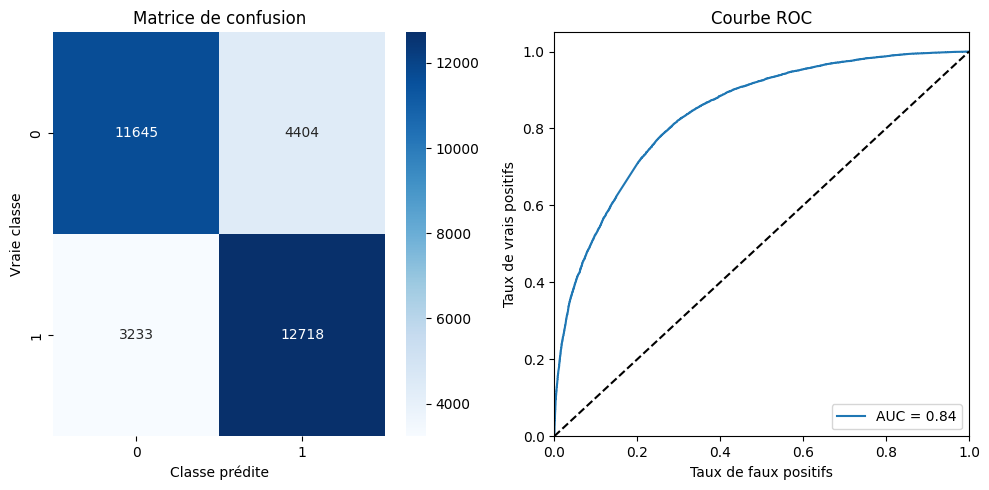

In [3]:
# Créer et entraîner le modèle de régression logistique
model_lr = LogisticRegression(solver='liblinear', max_iter=1000)

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    model_lr.fit(X_train_tfidf, y_train)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lr, X_test_tfidf, y_test)

    # Enregistrer les paramètres
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("solver", "liblinear")
    mlflow.log_param("max_iter", 1000)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)  

    # Ajouter un tag
    mlflow.set_tag("model_name", "LogisticRegression")

    # Enregistrer le modèle avec pickle
    with open('../models/model_lr.pkl', 'wb') as f:
        pickle.dump(model_lr, f)
        
    # Enregistrer le modèle avec mlflow
    mlflow.sklearn.log_model(model_lr,
                             "model_lr",
                            input_example =  X_train_tfidf[:5])

### 3.1.2 - Logreg + Doc2Vec

Accuracy: 0.6940
Precision: 0.6944
Recall: 0.6897
F1-score: 0.6920
Prediction Time: 0.0845 seconds


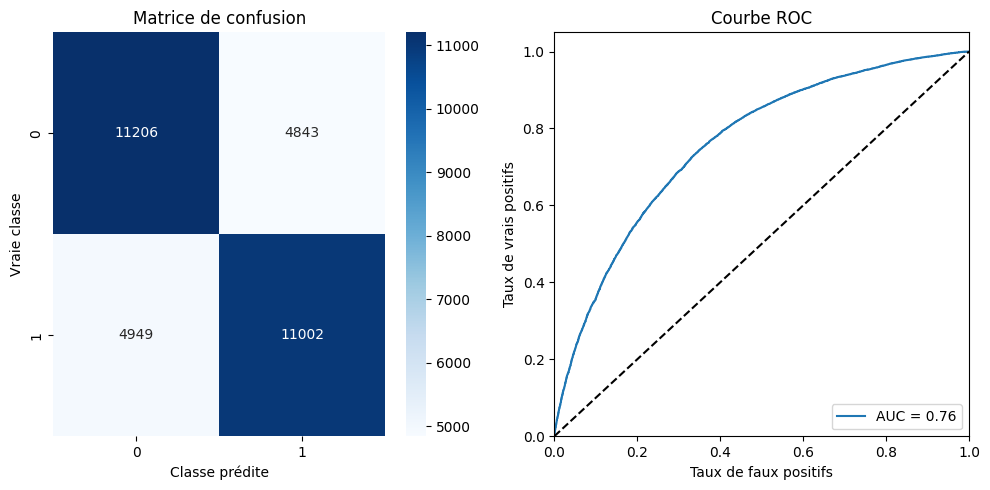

In [4]:

# Créer et entraîner le modèle de régression logistique
model_lr_Doc2vec = LogisticRegression(solver='liblinear',
                                      max_iter=1000)

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    model_lr_Doc2vec.fit(X_train_d2v, y_train)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lr_Doc2vec,
                                                                              X_test_d2v,
                                                                              y_test)

    # Enregistrer les paramètres
    mlflow.log_param("model", "LogisticRegression_Doc2vec")
    mlflow.log_param("solver", "liblinear")
    mlflow.log_param("max_iter", 1000)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)  # Enregistrer le predict_time

    # Ajouter un tag
    mlflow.set_tag("model_name", "LogisticRegression_Doc2Vec")

    # Enregistrer le modèle avec mlflow
    mlflow.sklearn.log_model(model_lr_Doc2vec,
                             "model_lr_doc2vec",
                            input_example = X_train_d2v[:5])

### 3.1.3 - Logreg + Word2Vec

Accuracy: 0.7254
Precision: 0.7187
Recall: 0.7381
F1-score: 0.7282
Prediction Time: 0.0301 seconds


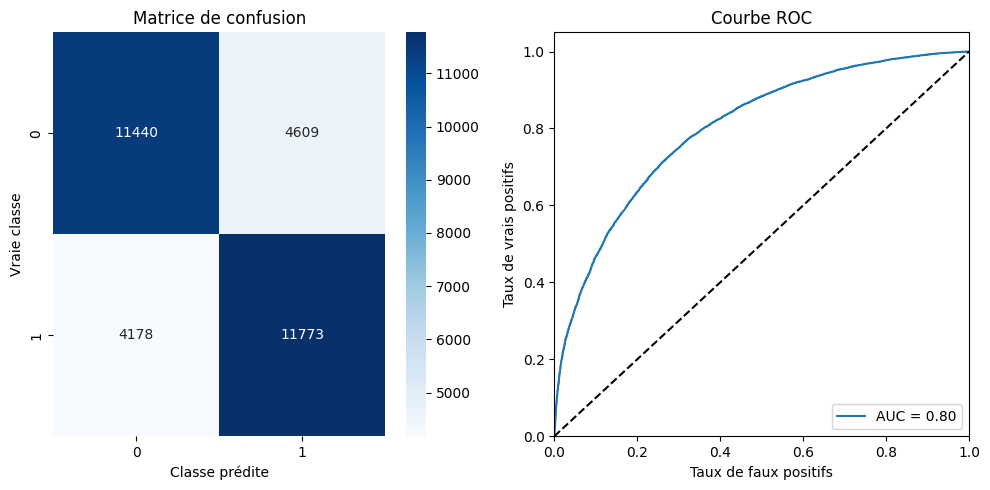

In [5]:
# Créer et entraîner le modèle de régression logistique
model_lr_w2v = LogisticRegression(solver='liblinear',
                                  max_iter=1000)

# Démarrer une exécution MLflow
with mlflow.start_run():
    try:
        # Entraîner le modèle
        model_lr_w2v.fit(X_train_w2v, y_train)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lr_w2v,
                                                                       X_test_w2v,
                                                                       y_test)
    except KeyboardInterrupt:
        print("Entraînement interrompu")

    # Enregistrer les paramètres
    mlflow.log_param("model", "LogisticRegression_Word2Vec")  # Nom descriptif
    mlflow.log_param("solver", "liblinear")
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("random_state", 42) # Ajouter le random state

    # Enregistrer les métriques
    if 'accuracy' in locals():
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag
    mlflow.set_tag("model_name", "LogisticRegression_Word2Vec")

    # Enregistrer le modèle avec mlflow
    mlflow.sklearn.log_model(model_lr_w2v,
                             "model_lr_word2vec",
                            input_example = X_train_w2v[:5]) 

### 3.2.1 - MLP + TF-IDF

Epoch 1/10


2025-02-09 16:44:49.409736: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 409600000 exceeds 10% of free system memory.


12800/12800 [==============================] - 80s 6ms/step - loss: 0.5090 - accuracy: 0.7508 - val_loss: 0.4899 - val_accuracy: 0.7589
Epoch 2/10
12800/12800 [==============================] - 60s 5ms/step - loss: 0.4848 - accuracy: 0.7671 - val_loss: 0.4862 - val_accuracy: 0.7627
Epoch 3/10
12800/12800 [==============================] - 61s 5ms/step - loss: 0.4729 - accuracy: 0.7751 - val_loss: 0.4896 - val_accuracy: 0.7619
Epoch 4/10
12800/12800 [==============================] - 60s 5ms/step - loss: 0.4605 - accuracy: 0.7833 - val_loss: 0.5000 - val_accuracy: 0.7655
Epoch 5/10
12800/12800 [==============================] - 60s 5ms/step - loss: 0.4472 - accuracy: 0.7917 - val_loss: 0.4914 - val_accuracy: 0.7638
Epoch 6/10
12800/12800 [==============================] - 61s 5ms/step - loss: 0.4318 - accuracy: 0.8009 - val_loss: 0.4969 - val_accuracy: 0.7624
Epoch 7/10
12800/12800 [==============================] - 60s 5ms/step - loss: 0.4161 - accuracy: 0.8110 - val_loss: 0.5076 - val

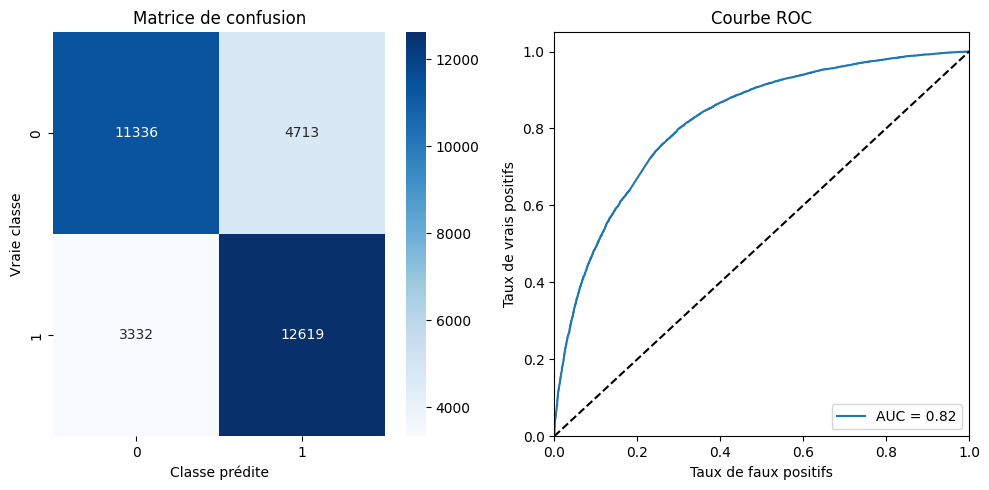

2025/02/09 16:55:31 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: MlflowException("Unsupported input data type: <class 'scipy.sparse._csr.csr_matrix'>. Must be one of: ['ndarray', 'list', 'tuple', 'dict']"). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`. To disable automatic signature inference, set `signature` to `False` in your `log_model` or `save_model` call.
2025/02/09 16:55:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpcr3r7w_o/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpcr3r7w_o/model/data/model/assets
2025/02/09 16:55:37 WARNING mlflow.utils.requirements_utils: Failed to run predict on input_example, dependencies introduced in predict are not captured.
MlflowException("Unsupported input data type: <class 'scipy.sparse._csr.csr_matrix'>. Must be one of: ['ndarray', 'list', 'tuple', 'dict']")Traceback (most recent call last):


  File "/home/mehdi/Documents/OC/OC7/.venv/lib/python3.8/site-packages/mlflow/utils/_capture_modules.py", line 166, in load_model_and_predict
    model.predict(input_example, params=params)


  File "/home/mehdi/Documents/OC/OC7/.venv/lib/python3.8/site-packages/mlflow/tensorflow/__init__.py", line 897, in predict
    raise MlflowException(


mlflow.exceptions.MlflowException: Unsupported input data type: <class 'scipy.sparse._csr.csr_matrix'>. Must be one of: ['ndarray', 'list', 'tuple', 'dict']


1/1 [==============================] - 0s 58ms/step


In [6]:
# Créer et entraîner le modèle MLP
model_mlp = model.create_mlp_model(input_shape=(X_train_tfidf.shape[1],))

# Démarrer une exécution MLflow
with mlflow.start_run():
    try:
        # Paramètres
        n_epochs = 10
        batch_size = 8
        # Entraîner le modèle
        model_mlp.fit(X_train_tfidf.toarray(),  # Convertir en array dense
                    y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_split=0.2)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_mlp,
                                                                                  X_test_tfidf.toarray(),
                                                                                  y_test)

    except KeyboardInterrupt:
         print("Entraînement interrompu")

    # Enregistrer les paramètres
    mlflow.log_param("model", "MLP_TFIDF")  # Nom descriptif
    mlflow.log_param("epochs", n_epochs)
    mlflow.log_param("batch_size", batch_size)

    # Enregistrer les métriques
    if 'accuracy' in locals():
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag
    mlflow.set_tag("model_name", "MLP_TFIDF")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_mlp,
                           "model_mlp_tfidf",
                           input_example = X_train_tfidf[:5])  


### 3.2.2 - MLP + Word2Vec

Epoch 1/10
12800/12800 [==============================] - 42s 3ms/step - loss: 0.5729 - accuracy: 0.7021 - val_loss: 0.5553 - val_accuracy: 0.7149
Epoch 2/10
12800/12800 [==============================] - 39s 3ms/step - loss: 0.5589 - accuracy: 0.7138 - val_loss: 0.5481 - val_accuracy: 0.7200
Epoch 3/10
12800/12800 [==============================] - 39s 3ms/step - loss: 0.5545 - accuracy: 0.7165 - val_loss: 0.5443 - val_accuracy: 0.7204
Epoch 4/10
12800/12800 [==============================] - 39s 3ms/step - loss: 0.5532 - accuracy: 0.7180 - val_loss: 0.5532 - val_accuracy: 0.7156
Epoch 5/10
12800/12800 [==============================] - 39s 3ms/step - loss: 0.5517 - accuracy: 0.7206 - val_loss: 0.5475 - val_accuracy: 0.7252
Epoch 6/10
12800/12800 [==============================] - 39s 3ms/step - loss: 0.5492 - accuracy: 0.7221 - val_loss: 0.5444 - val_accuracy: 0.7263
Epoch 7/10
12800/12800 [==============================] - 39s 3ms/step - loss: 0.5479 - accuracy: 0.7221 - val_loss: 0

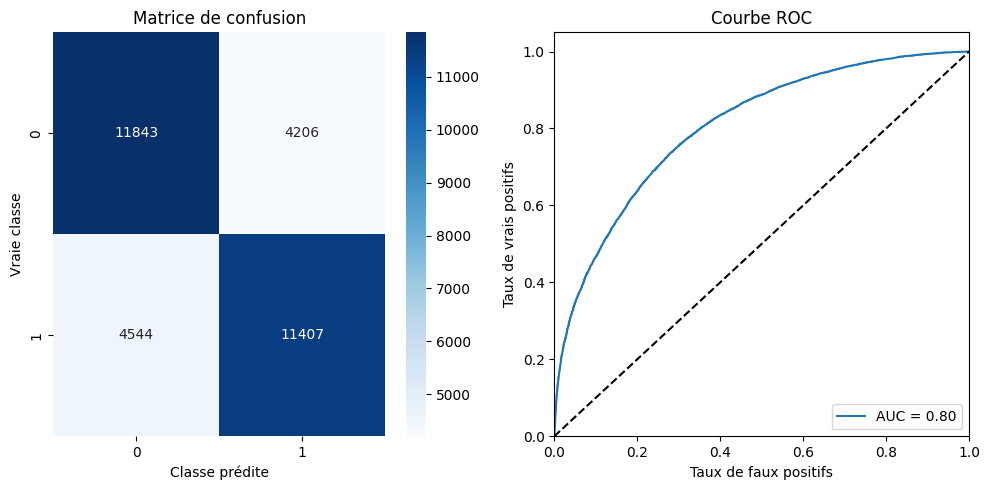

1/1 [==============================] - 0s 55ms/step
INFO:tensorflow:Assets written to: /tmp/tmpjpw4e1s6/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpjpw4e1s6/model/data/model/assets


1/1 [==============================] - 0s 56ms/step


In [7]:
# Créer et entraîner le modèle MLP
model_mlp = model.create_mlp_model(input_shape=(X_train_w2v.shape[1],))

# Démarrer une exécution MLflow
with mlflow.start_run():
    try:
        # Entraîner le modèle
        model_mlp.fit(X_train_w2v,
                      y_train,
                      epochs=10,
                      batch_size=8,
                      validation_split=0.2)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_mlp,
                                                                                  X_test_w2v,
                                                                                  y_test)

    except KeyboardInterrupt:
        print("Entrainement interrompu")

    # Enregistrer les paramètres
    mlflow.log_param("model", "MLP_Word2Vec") # Nom du modèle descriptif
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 8)
    # Ajoutez d'autres hyperparamètres si vous en avez

    # Enregistrer les métriques
    if 'accuracy' in locals():
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "MLP_Word2Vec")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_mlp,
                           "model_mlp_w2v",
                          input_example = X_train_w2v[:5]) 


### 3.3.1 - CNN + TF-IDF

2025-02-09 17:02:25.239331: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 409600000 exceeds 10% of free system memory.


Epoch 1/10
12800/12800 [==============================] - 251s 20ms/step - loss: 0.5243 - accuracy: 0.7411 - val_loss: 0.5079 - val_accuracy: 0.7498
Epoch 2/10
12800/12800 [==============================] - 275s 21ms/step - loss: 0.5042 - accuracy: 0.7552 - val_loss: 0.5035 - val_accuracy: 0.7525
Epoch 3/10
12800/12800 [==============================] - 262s 20ms/step - loss: 0.4992 - accuracy: 0.7585 - val_loss: 0.5008 - val_accuracy: 0.7550
Epoch 4/10
12800/12800 [==============================] - 252s 20ms/step - loss: 0.4962 - accuracy: 0.7594 - val_loss: 0.5000 - val_accuracy: 0.7549
Epoch 5/10
12800/12800 [==============================] - 234s 18ms/step - loss: 0.4940 - accuracy: 0.7612 - val_loss: 0.4985 - val_accuracy: 0.7580
Epoch 6/10
12800/12800 [==============================] - 244s 19ms/step - loss: 0.4927 - accuracy: 0.7621 - val_loss: 0.4987 - val_accuracy: 0.7568
Epoch 7/10
12800/12800 [==============================] - 269s 21ms/step - loss: 0.4913 - accuracy: 0.7631

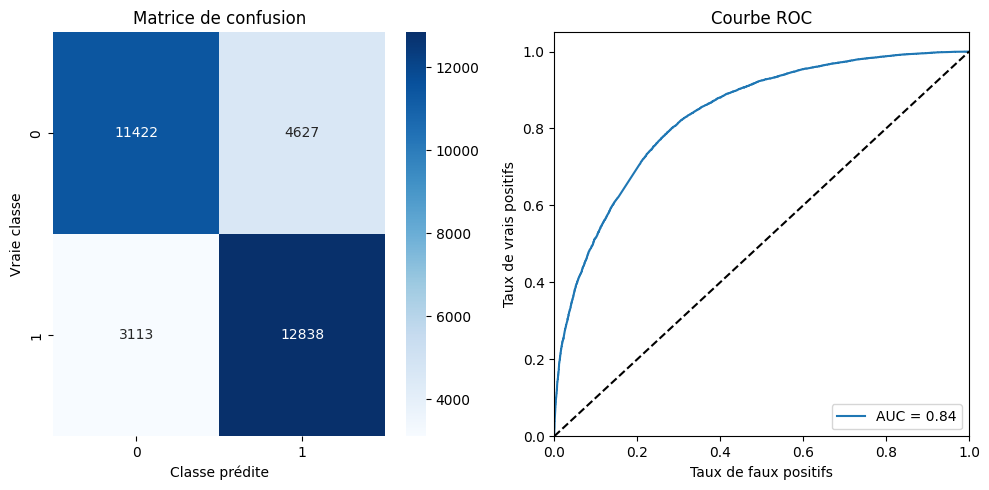

1/1 [==============================] - 0s 99ms/step
INFO:tensorflow:Assets written to: /tmp/tmpqdnj4gso/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpqdnj4gso/model/data/model/assets


1/1 [==============================] - 0s 72ms/step


In [8]:
# Reshape des données TF-IDF pour le CNN (IMPORTANT: conversion en dense + ajout de la dimension canal)
X_train_cnn = X_train_tfidf.toarray()  # Convertit en array dense
X_train_cnn = np.reshape(X_train_cnn, (X_train_cnn.shape[0], X_train_cnn.shape[1], 1))

X_test_cnn = X_test_tfidf.toarray()  # Convertit en array dense
X_test_cnn = np.reshape(X_test_cnn, (X_test_cnn.shape[0], X_test_cnn.shape[1], 1))

# Créer le modèle CNN
model_cnn = model.create_cnn_model(input_shape=(X_train_cnn.shape[1], 1))  # input_shape correcte

# Démarrer une exécution MLflow
with mlflow.start_run():
    try:
        # Entraîner le modèle
        model_cnn.fit(X_train_cnn,
                    y_train,
                    epochs=10,
                    batch_size=8,
                    validation_split=0.2)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_cnn,
                                                                                  X_test_cnn,
                                                                                  y_test)
    except KeyboardInterrupt:
        print("Entrainement interrompu")

    # Enregistrer les paramètres
    mlflow.log_param("model", "CNN_TFIDF")  # Nom descriptif
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 8)

    # Enregistrer les métriques
    if 'accuracy' in locals():
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag
    mlflow.set_tag("model_name", "CNN_TFIDF")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_cnn,
                           "model_cnn_tfidf",
                          input_example = X_train_cnn[:5]) 


### 3.3.2 - CNN + Word2Vec

Epoch 1/10
12800/12800 [==============================] - 149s 12ms/step - loss: 0.5582 - accuracy: 0.7102 - val_loss: 0.5423 - val_accuracy: 0.7190
Epoch 2/10
12800/12800 [==============================] - 152s 12ms/step - loss: 0.5440 - accuracy: 0.7199 - val_loss: 0.5400 - val_accuracy: 0.7239
Epoch 3/10
12800/12800 [==============================] - 146s 11ms/step - loss: 0.5405 - accuracy: 0.7223 - val_loss: 0.5439 - val_accuracy: 0.7193
Epoch 4/10
12800/12800 [==============================] - 145s 11ms/step - loss: 0.5377 - accuracy: 0.7259 - val_loss: 0.5401 - val_accuracy: 0.7188
Epoch 5/10
12800/12800 [==============================] - 145s 11ms/step - loss: 0.5358 - accuracy: 0.7268 - val_loss: 0.5404 - val_accuracy: 0.7190
Epoch 6/10
12800/12800 [==============================] - 145s 11ms/step - loss: 0.5344 - accuracy: 0.7268 - val_loss: 0.5389 - val_accuracy: 0.7227
Epoch 7/10
12800/12800 [==============================] - 143s 11ms/step - loss: 0.5330 - accuracy: 0.7289

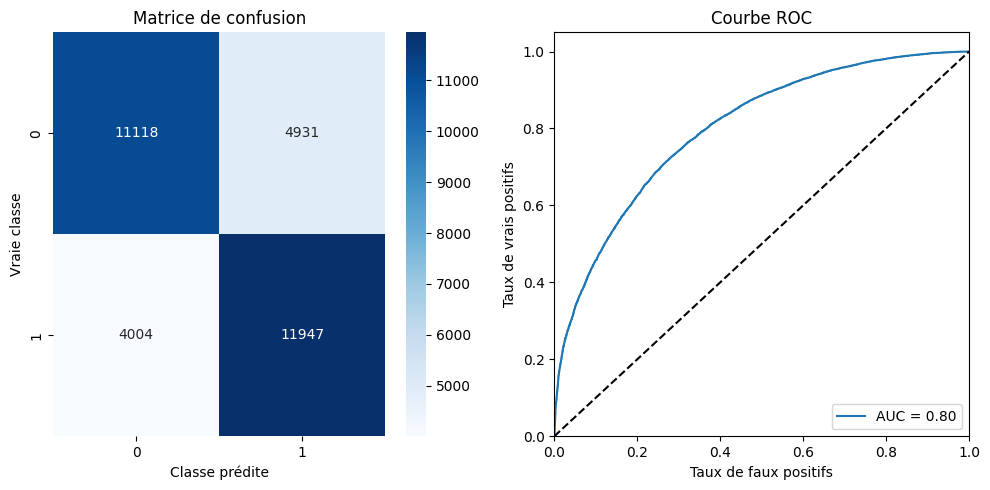

1/1 [==============================] - 0s 102ms/step
INFO:tensorflow:Assets written to: /tmp/tmpxv34bcar/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpxv34bcar/model/data/model/assets


1/1 [==============================] - 0s 73ms/step


In [9]:
# Reshape des données Word2Vec pour le modèle CNN
X_train_cnn = np.reshape(X_train_w2v, (X_train_w2v.shape[0], X_train_w2v.shape[1], 1))
X_test_cnn = np.reshape(X_test_w2v, (X_test_w2v.shape[0], X_test_w2v.shape[1], 1))

# Créer le modèle CNN
model_cnn = model.create_cnn_model(input_shape=(X_train_cnn.shape[1], 1))

# Démarrer une exécution MLflow
with mlflow.start_run():
    try:
        # Entraîner le modèle
        model_cnn.fit(X_train_cnn,
                    y_train,
                    epochs=10,
                    batch_size=8,
                    validation_split=0.2)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_cnn, X_test_cnn, y_test)
    except KeyboardInterrupt:
        print("Entraînement interrompu")

    # Enregistrer les paramètres
    mlflow.log_param("model", "CNN_Word2Vec")  # Nom de modèle descriptif
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 8)
    # Enregistrez d'autres hyperparamètres

    # Enregistrer les métriques
    if 'accuracy' in locals():
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "CNN_Word2Vec")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_cnn,
                           "model_cnn_w2v",
                          input_example = X_train_cnn[:5]) 


### 3.4 - LSTM + Word2Vec + Optimisation Batch size

Epoch 1/10
6400/6400 [==============================] - 769s 120ms/step - loss: 0.5346 - accuracy: 0.7277 - val_loss: 0.5133 - val_accuracy: 0.7420
Epoch 2/10
6400/6400 [==============================] - 781s 122ms/step - loss: 0.5099 - accuracy: 0.7473 - val_loss: 0.5039 - val_accuracy: 0.7491
Epoch 3/10
6400/6400 [==============================] - 804s 126ms/step - loss: 0.5012 - accuracy: 0.7518 - val_loss: 0.5022 - val_accuracy: 0.7509
Epoch 4/10
6400/6400 [==============================] - 809s 126ms/step - loss: 0.4952 - accuracy: 0.7563 - val_loss: 0.4994 - val_accuracy: 0.7534
Epoch 5/10
6400/6400 [==============================] - 794s 124ms/step - loss: 0.4891 - accuracy: 0.7598 - val_loss: 0.5007 - val_accuracy: 0.7578
Epoch 6/10
6400/6400 [==============================] - 791s 124ms/step - loss: 0.4849 - accuracy: 0.7624 - val_loss: 0.4954 - val_accuracy: 0.7547
Epoch 7/10
6400/6400 [==============================] - 828s 129ms/step - loss: 0.4778 - accuracy: 0.7666 - val_

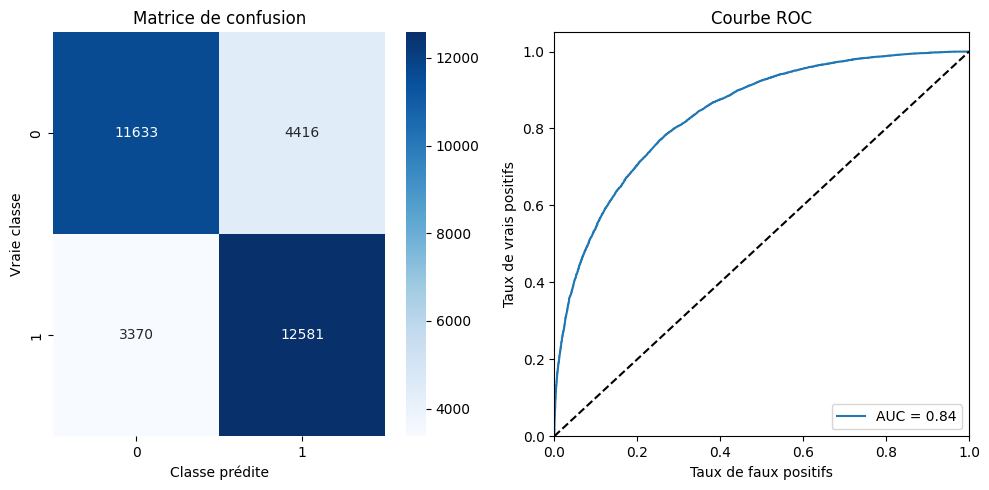

2025/02/09 20:26:28 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmp5cycuijk/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp5cycuijk/model/data/model/assets
2025/02/09 20:26:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 1/10
3200/3200 [==============================] - 590s 184ms/step - loss: 0.5377 - accuracy: 0.7255 - val_loss: 0.5208 - val_accuracy: 0.7383
Epoch 2/10
3200/3200 [==============================] - 570s 178ms/step - loss: 0.5088 - accuracy: 0.7474 - val_loss: 0.5022 - val_accuracy: 0.7508
Epoch 3/10
3200/3200 [==============================] - 558s 174ms/step - loss: 0.4997 - accuracy: 0.7522 - val_loss: 0.4960 - val_accuracy: 0.7561
Epoch 4/10
3200/3200 [==============================] - 567s 177ms/step - loss: 0.4926 - accuracy: 0.7572 - val_loss: 0.4936 - val_accuracy: 0.7568
Epoch 5/10
3200/3200 [==============================] - 553s 173ms/step - loss: 0.4867 - accuracy: 0.7612 - val_loss: 0.4952 - val_accuracy: 0.7571
Epoch 6/10
3200/3200 [==============================] - 556s 174ms/step - loss: 0.4816 - accuracy: 0.7645 - val_loss: 0.4901 - val_accuracy: 0.7593
Epoch 7/10
3200/3200 [==============================] - 562s 176ms/step - loss: 0.4753 - accuracy: 0.7688 - val_

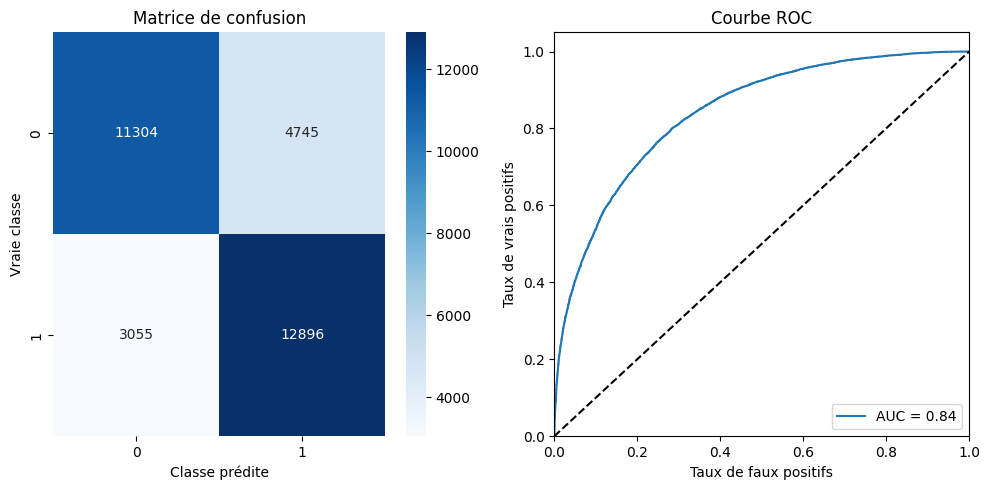

2025/02/09 22:02:38 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpxu3lbvio/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpxu3lbvio/model/data/model/assets
2025/02/09 22:02:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 1/10
1600/1600 [==============================] - 402s 250ms/step - loss: 0.5410 - accuracy: 0.7219 - val_loss: 0.5173 - val_accuracy: 0.7391
Epoch 2/10
1600/1600 [==============================] - 409s 256ms/step - loss: 0.5111 - accuracy: 0.7462 - val_loss: 0.5104 - val_accuracy: 0.7461
Epoch 3/10
1600/1600 [==============================] - 399s 249ms/step - loss: 0.5014 - accuracy: 0.7508 - val_loss: 0.4992 - val_accuracy: 0.7534
Epoch 4/10
1600/1600 [==============================] - 396s 248ms/step - loss: 0.4933 - accuracy: 0.7569 - val_loss: 0.4960 - val_accuracy: 0.7534
Epoch 5/10
1600/1600 [==============================] - 399s 249ms/step - loss: 0.4877 - accuracy: 0.7609 - val_loss: 0.5011 - val_accuracy: 0.7506
Epoch 6/10
1600/1600 [==============================] - 397s 248ms/step - loss: 0.4815 - accuracy: 0.7649 - val_loss: 0.4994 - val_accuracy: 0.7541
Epoch 7/10
1600/1600 [==============================] - 398s 249ms/step - loss: 0.4762 - accuracy: 0.7674 - val_

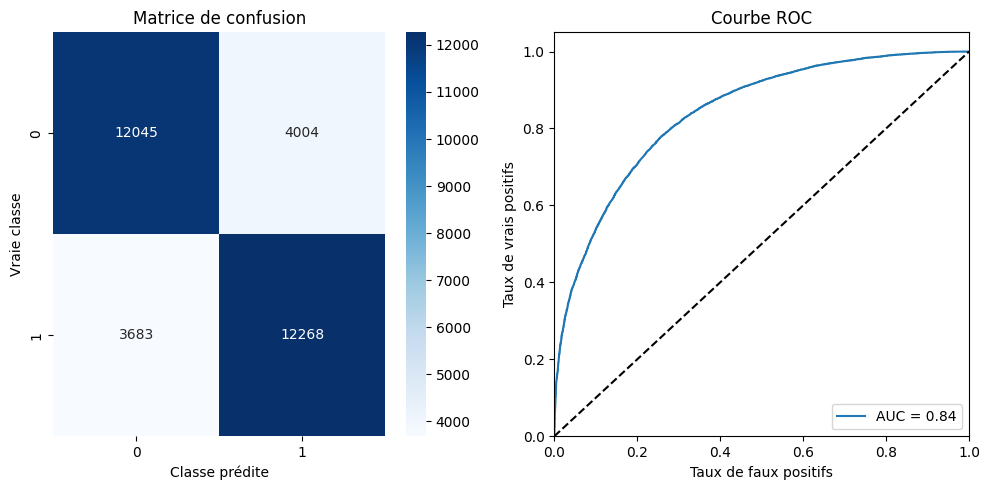

2025/02/09 23:11:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpwlxgipis/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpwlxgipis/model/data/model/assets
2025/02/09 23:11:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 1/10
800/800 [==============================] - 323s 400ms/step - loss: 0.5480 - accuracy: 0.7161 - val_loss: 0.5213 - val_accuracy: 0.7378
Epoch 2/10
800/800 [==============================] - 323s 404ms/step - loss: 0.5158 - accuracy: 0.7425 - val_loss: 0.5074 - val_accuracy: 0.7475
Epoch 3/10
800/800 [==============================] - 319s 398ms/step - loss: 0.5045 - accuracy: 0.7495 - val_loss: 0.5021 - val_accuracy: 0.7501
Epoch 4/10
800/800 [==============================] - 318s 398ms/step - loss: 0.4972 - accuracy: 0.7539 - val_loss: 0.4969 - val_accuracy: 0.7514
Epoch 5/10
800/800 [==============================] - 322s 403ms/step - loss: 0.4909 - accuracy: 0.7577 - val_loss: 0.5007 - val_accuracy: 0.7534
Epoch 6/10
800/800 [==============================] - 318s 397ms/step - loss: 0.4852 - accuracy: 0.7626 - val_loss: 0.4954 - val_accuracy: 0.7564
Epoch 7/10
800/800 [==============================] - 318s 397ms/step - loss: 0.4807 - accuracy: 0.7647 - val_loss: 0.4927 -

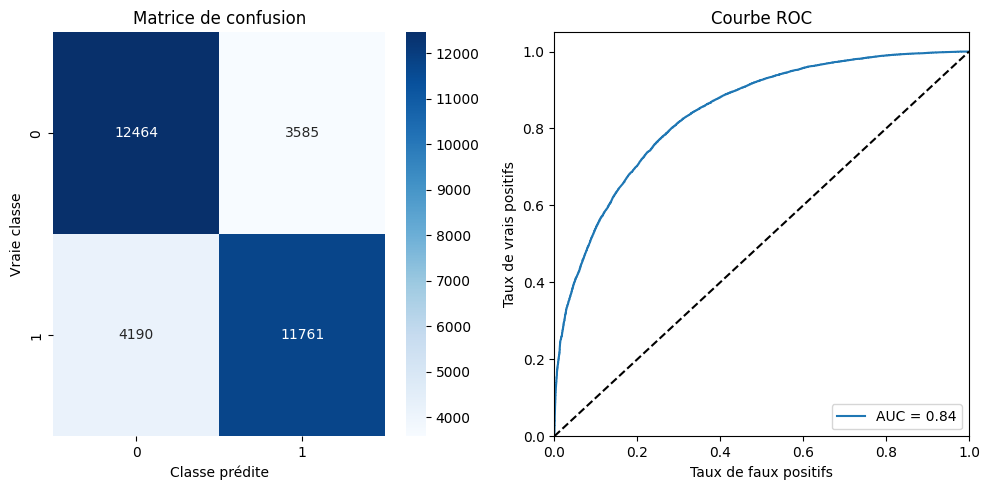

2025/02/10 00:07:19 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmppzxenj8h/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmppzxenj8h/model/data/model/assets
2025/02/10 00:07:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Meilleur batch_size : 64


In [10]:
# Entraîner le modèle Word2Vec sur les tweets prétraités
sentences = [tweet.split() for tweet in X_train]
model_w2v = Word2Vec(sentences,
                     vector_size=500,
                     window=5,
                     min_count=1,
                     workers=4)

# Créer la matrice d'embedding
embedding_matrix = np.zeros((len(model_w2v.wv), 500))

# Itérer sur les mots du vocabulaire
for i, word in enumerate(model_w2v.wv.index_to_key):  # Utiliser index_to_key pour obtenir les mots
    embedding_matrix[i] = model_w2v.wv[word]

# Entraîner le modèle sur les données d'entraînement
X_train_w2v = [[model_w2v.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_train]
X_test_w2v = [[model_w2v.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_test]

# Remplir les séquences avec des zéros pour qu'elles aient toutes la même longueur
max_length = 100  # Définir la longueur maximale des séquences
X_train_w2v = pad_sequences(X_train_w2v, maxlen=max_length)
X_test_w2v = pad_sequences(X_test_w2v, maxlen=max_length)

# Définir les valeurs de batch_size à tester
batch_sizes = [16, 32, 64, 128]

# Initialiser le meilleur batch_size et la meilleure accuracy
best_batch_size = None
best_accuracy = 0.0

for batch_size in batch_sizes:
    with mlflow.start_run():
        # Créer le modèle LSTM
        model_lstm = model.create_lstm_model(input_shape=(embedding_matrix.shape[0], embedding_matrix.shape[1]),
                                            embedding_matrix = embedding_matrix)

        # Entraîner le modèle avec le batch_size actuel
        model_lstm.fit(X_train_w2v, y_train, epochs=10, batch_size=batch_size, validation_split=0.2)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lstm, X_test_w2v, y_test)

        # Enregistrer les paramètres
        mlflow.log_param("model", "LSTM")
        mlflow.log_param("embedding", "Word2Vec")
        mlflow.log_param("epochs", 10)
        mlflow.log_param("batch_size", batch_size)

        # Enregistrer les métriques
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

        # Ajouter un tag pour identifier le modèle
        mlflow.set_tag("model_name", "LSTM_w2v")

        # Enregistrer le modèle
        mlflow.keras.log_model(model_lstm,
                               "model_lstm_w2v")

        # Mettre à jour le meilleur batch_size et la meilleure accuracy si nécessaire
        if accuracy > best_accuracy:
            best_batch_size = batch_size
            best_accuracy = accuracy

# Afficher le meilleur batch_size
print(f"Meilleur batch_size : {best_batch_size}")

### 3.5 - LSTM + FastText

model_ft = FastText(sentences, vector_size=100, window=5, min_count=1, workers=4)

Le code ci-dessus crée un modèle Word2Vec en utilisant la librairie Gensim. Voici une explication des paramètres :

*   `sentences` : une liste de phrases tokenisées qui seront utilisées pour entraîner le modèle.
*   `vector_size` : la dimensionnalité des vecteurs de mots (word embeddings). Ici, chaque mot sera représenté par un vecteur de 100 dimensions.
*   `window` : la taille de la fenêtre de contexte. Le modèle va considérer 5 mots avant et 5 mots après chaque mot pour apprendre les relations entre les mots.
*   `min_count` : le nombre minimum d’occurrences d’un mot pour qu’il soit pris en compte dans le vocabulaire. Ici, tous les mots seront utilisés car `min_count=1`.
*   `workers` : le nombre de cœurs de processeur à utiliser pour l’entraînement.


In [ ]:


# Entraîner le modèle FastText sur les tweets prétraités
sentences = [tweet.split() for tweet in X_train]

vec_size = 300
model_ft = FastText(sentences, 
                    vector_size=vec_size,
                    window=5,
                    min_count=1,
                    workers=4)

# Créer la matrice d'embedding
embedding_matrix = np.zeros((len(model_ft.wv), vec_size))  # Forme (vocab_size, vec_size)

# Itérer sur les mots du vocabulaire
for i, word in enumerate(model_ft.wv.index_to_key):  # Utiliser index_to_key pour obtenir les mots
    embedding_matrix[i] = model_ft.wv[word]

# Définir le modèle LSTM avec la couche d'embedding FastText
model_lstm_ft = model.create_lstm_model(input_shape=(embedding_matrix.shape[0], embedding_matrix.shape[1]),
                                       embedding_matrix= embedding_matrix)

# Entraîner le modèle sur les données d'entraînement
X_train_ft = [[model_ft.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_train]
X_test_ft = [[model_ft.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_test]

# Remplir les séquences avec des zéros pour qu'elles aient toutes la même longueur
max_length = 100  # Définir la longueur maximale des séquences
X_train_ft = pad_sequences(X_train_ft, maxlen=max_length)
X_test_ft = pad_sequences(X_test_ft, maxlen=max_length)

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    history = model_lstm_ft.fit(X_train_ft,
                                y_train,
                                epochs=10,
                                batch_size=16,
                                validation_split=0.2)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lstm_ft, X_test_ft, y_test)

    # Enregistrer les paramètres
    mlflow.log_param("model", "LSTM")
    mlflow.log_param("embedding", "FastText")
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 16)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "LSTM_ft")

    # Enregistrer le modèle avec pickle
    with open('../models/model_lstm_ft.pkl', 'wb') as f:
        pickle.dump(model_lstm_ft, f)
    
    # Enregistrer le modèle
    mlflow.keras.log_model(model_lstm_ft, "model_lstm_ft")

2025-02-10 09:00:01.283485: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 84874800 exceeds 10% of free system memory.
2025-02-10 09:00:01.382289: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 84874800 exceeds 10% of free system memory.
2025-02-10 09:00:01.431053: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 84874800 exceeds 10% of free system memory.
2025-02-10 09:00:01.713305: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 84874800 exceeds 10% of free system memory.


Epoch 1/10


2025-02-10 09:00:03.954405: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40960000 exceeds 10% of free system memory.


   3/6400 [..............................] - ETA: 11:11 - loss: 0.7417 - accuracy: 0.4792  

### 3.6 - DistilBERT (1% des données)

In [ ]:
# --- Échantillonnage de 10% des données d'entraînement ---
X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train, train_size=0.1, stratify=y_train
)

# Créer et entraîner le modèle DistilBERT
model_distilbert, tokenizer = model.create_distilbert_model("distilbert-base-uncased")

# Tokenizer les tweets d'entraînement (échantillon) et de test
X_train_distilbert = tokenizer(X_train_small.tolist(),
                               padding=True,
                               truncation=True,
                               return_tensors="tf")

X_test_distilbert = tokenizer(X_test.tolist(),
                              padding=True,
                              truncation=True,
                              return_tensors="tf")

# Convertir les labels en tenseurs (échantillon et test)
y_train_distilbert = tf.convert_to_tensor(y_train_small)
y_test_distilbert = tf.convert_to_tensor(y_test)


# Hyperparamètres
batch_size = 8  # Vous pouvez ajuster
epochs = 3      # Vous pouvez ajuster

# Démarrer une exécution MLflow
with mlflow.start_run():
    try:
        # Entraîner le modèle (sur l'échantillon)
        history = model_distilbert.fit(
            x={"input_ids": X_train_distilbert["input_ids"],
               "attention_mask": X_train_distilbert["attention_mask"]},
            y=y_train_distilbert,
            validation_split=0.2,  # Utiliser une partie de l'échantillon pour la validation
            epochs=epochs,
            batch_size=batch_size,
        )

        # Évaluer le modèle (sur l'ensemble de test *complet*)
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele_bert(
            model_distilbert,
            {"input_ids": X_test_distilbert["input_ids"], "attention_mask": X_test_distilbert["attention_mask"]},
            y_test_distilbert
        )
    except KeyboardInterrupt:
      print("Entraînement interrompu")

    # Enregistrer les paramètres
    mlflow.log_param("model", "DistilBERT")
    mlflow.log_param("model_name", "distilbert-base-uncased")
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("learning_rate", 5e-5)
    mlflow.log_param("train_size", 0.1)  # Log the training set size

    # Enregistrer les métriques
    if 'accuracy' in locals():
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "DistilBERT")
    mlflow.set_tag("train_size", "10%")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_distilbert, "model_distilbert")

### 3.7 - USE

In [ ]:
import tensorflow_hub as hub

# Charger le modèle USE
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Encoder les tweets
X_train_use = embed(X_train)
X_test_use = embed(X_test)

# Créer le modèle USE
model_use = model.create_use_model(input_shape=(X_train_use.shape[1],))

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    model_use.fit(X_train_use,
                  y_train,
                  epochs=10,
                  batch_size=32,
                  validation_split=0.2)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_use,
                                                                              X_test_use,
                                                                              y_test)

    # Enregistrer les paramètres
    # (Ajouter ici les paramètres du modèle USE)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "USE")
    
    # Enregistrer le modèle
    mlflow.keras.log_model(model_use, "model_use")

## 4. Comparaison des modèles

In [ ]:
import mlflow
import pandas as pd

# Fonction pour récupérer les métriques d'une exécution MLflow
def get_metrics_from_mlflow(model_name):
    # Rechercher l'exécution avec le tag "model_name"
    runs = mlflow.search_runs(filter_string=f"tags.model_name = '{model_name}'")  # Correction: tags.model_name
    if runs.empty:
        raise ValueError(f"Aucune exécution trouvée avec le tag 'model_name' = '{model_name}'")

    # Récupérer les métriques de la dernière exécution (la plus récente)
    last_run = runs.sort_values(by='start_time', ascending=False).iloc[0] # Correction: trier par start_time
    return (
        last_run["metrics.accuracy"],
        last_run["metrics.precision"],
        last_run["metrics.recall"],
        last_run["metrics.f1_score"],
        last_run["metrics.predict_time"]
    )

# Liste des noms de modèles CORRECTS (ceux utilisés avec mlflow.set_tag)
noms_modeles = [
    "LogisticRegression",
    "LogisticRegression_Word2Vec",
    "LogisticRegression_Doc2Vec",
    "MLP_TFIDF",
    "MLP_Word2Vec",
    "CNN_TFIDF",
    "CNN_Word2Vec",
    "LSTM_w2v",  # Assurez-vous que ce tag correspond à celui utilisé lors de l'entraînement du LSTM
    "LSTM_ft",    # Assurez-vous que ce tag correspond à celui utilisé lors de l'entraînement du LSTM
    "DistilBERT",
    "USE"  # Assurez-vous d'avoir bien entraîné et enregistré un modèle USE avec ce tag
]

# Calculer les métriques pour chaque modèle
resultats = []
for model_name in noms_modeles:
    try:
        resultats.append(get_metrics_from_mlflow(model_name))
    except ValueError as e:
        print(f"Erreur pour le modèle {model_name}: {e}")
        resultats.append((None, None, None, None, None))  # Ajouter des valeurs nulles si le modèle n'est pas trouvé

# Créer un DataFrame pour afficher les résultats
comparaison = pd.DataFrame(resultats, columns=['Accuracy', 'Precision', 'Recall', 'F1-score', 'Predict Time'], index=noms_modeles)

# Afficher les résultats
print(comparaison)

# Optionnel : Visualisation avec Matplotlib/Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(comparaison.dropna(), annot=True, cmap="viridis", fmt=".3f")  # Utiliser dropna() pour gérer les valeurs manquantes
plt.title("Comparaison des métriques des modèles")
plt.show()

# Bar plot pour l'accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x=comparaison.index, y=comparaison['Accuracy'])
plt.xticks(rotation=45, ha="right")
plt.title("Accuracy des modèles")
plt.tight_layout()
plt.show()

# Bar plot pour le F1-score
plt.figure(figsize=(10, 6))
sns.barplot(x=comparaison.index, y=comparaison['F1-score'])
plt.xticks(rotation=45, ha="right")
plt.title("F1-score des modèles")
plt.tight_layout()
plt.show()